In [1]:
import sys
sys.path.append('../src')
from preamble import *

# get data files
files_dict = walk_directory(raw_data,print_files=False)
drews_data = list(files_dict.keys())
drews_data.remove('pump')
drews_data.remove('Andrew_sleep') # not tracked

In [2]:
from datetime import timedelta,datetime
def get_data(filename):
    return (pd.read_csv(filename)
             .drop(columns=['Baby'])
             .assign(Time= lambda x: pd.to_datetime(x.Time))
             .set_index('Time',drop=True))

def get_days_between(datePast, dateFuture):
   difference = dateFuture - datePast
   return difference.total_seconds() / timedelta(days=1).total_seconds()

## Diaper Habits

In [3]:
diaper_df = get_data(files_dict['Andrew_diaper'])
diaper_df['hour_of_day'] = [x.hour for x in diaper_df.index]
diaper_df = pd.concat((diaper_df,pd.get_dummies(diaper_df.Status)),axis=1)
diaper_df.Dirty = diaper_df.Dirty | diaper_df.Mixed
diaper_df.Wet = diaper_df.Wet | diaper_df.Mixed

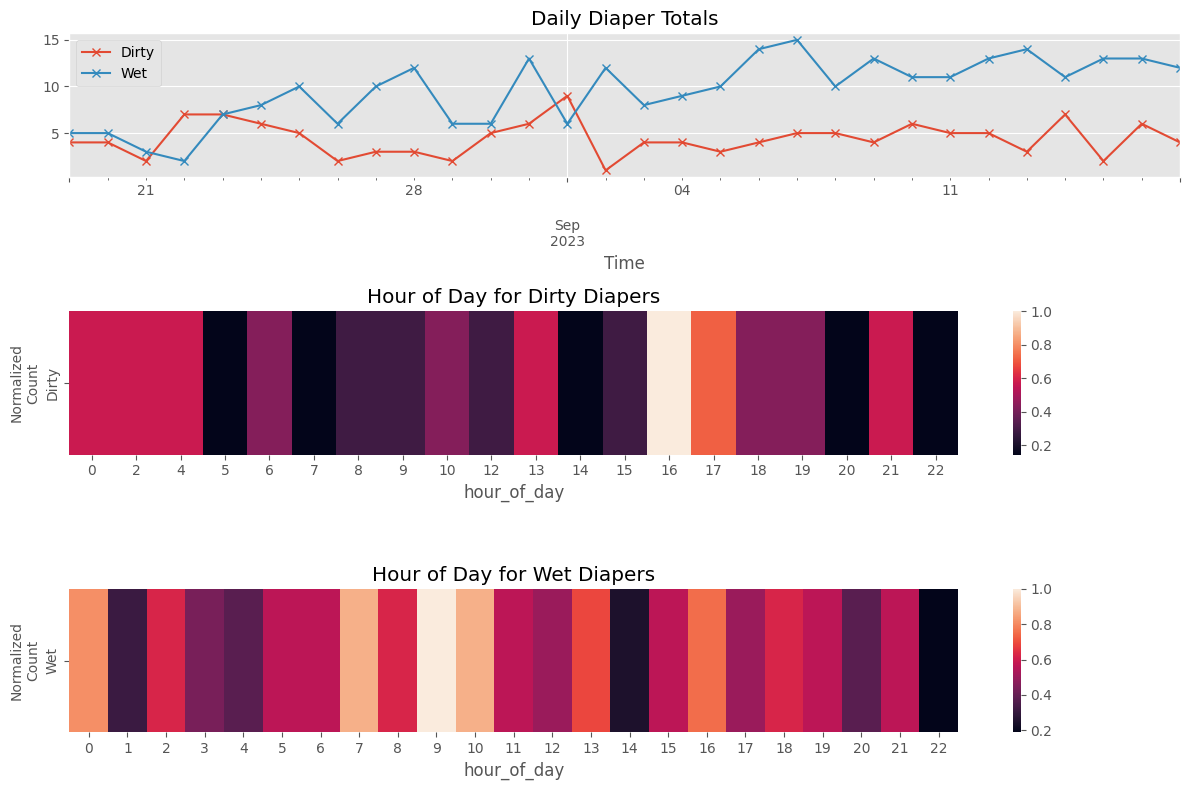

In [4]:
f,axes = plt.subplots(nrows=3,ncols=1,figsize=(12,8))
axes = axes.ravel()
ax = diaper_df[['Dirty','Wet']].resample('D').sum().iloc[:-1].plot(marker='x',ax=axes[0])
ax.set_title('Daily Diaper Totals')
for ax,status in zip(axes[1:],['Dirty','Wet']):
    tdf = diaper_df[diaper_df.Status == status].groupby('hour_of_day').sum().iloc[:-1]
    tdf[status] = tdf[status]/tdf[status].abs().max()
    ax = sns.heatmap(data=tdf[[status]].transpose(),ax=ax)
    ax.set_ylabel('Normalized\nCount',fontsize=10)
    ax.set_title(f'Hour of Day for {status} Diapers')
plt.tight_layout()

## Predict Return to Birth Weight

In [5]:
import statsmodels.api as sm

growth_df = get_data(files_dict['Andrew_growth'])
growth_df['days'] = [get_days_between(growth_df.index[0],x) for x in growth_df.index]
growth_df['sq_days'] = growth_df['days']*growth_df['days']
started_eating_filter = growth_df.days>2
model = sm.OLS(growth_df[started_eating_filter]['Weight (lbs.)'].values,
             sm.add_constant(growth_df[started_eating_filter][['days','sq_days']].values))
res = model.fit()
display(res.summary())
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]
growth_df['pred'] = np.append(np.full(sum(~started_eating_filter), fill_value=np.nan),res.fittedvalues)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     635.4
Date:                Mon, 18 Sep 2023   Prob (F-statistic):           1.53e-09
Time:                        00:34:55   Log-Likelihood:                 24.430
No. Observations:                  11   AIC:                            -42.86
Df Residuals:                       8   BIC:                            -41.67
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7577      0.032     86.910      0.000       2.684       2.831
x1             0.0277      0.005      5.537      0.001       0.016       0.039
x2             0.0005      0.000      3.101      0.015       0.000       0.001
==============================================================================
Omnibus:                        3.762   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.152   Jarque-Bera (JB):                1.578
Skew:                           0.921   Prob(JB):                        0.454
Kurtosis:                       3.221   Cond. No.                     1.12e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

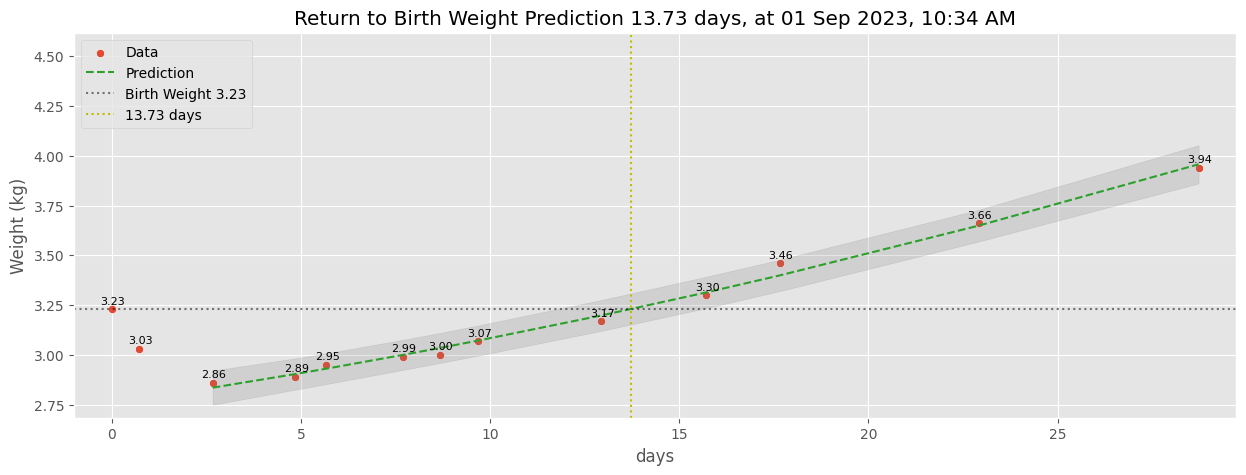

In [26]:
birth_weight = growth_df.at[growth_df.index[0],'Weight (lbs.)']
ax = sns.scatterplot(data=growth_df,x='days',y='Weight (lbs.)',label='Data')
ax = sns.lineplot(data=growth_df[started_eating_filter],x='days',y='pred',color='tab:green',
                  linestyle='dashed',label='Prediction')
ax.axhline(birth_weight,label=f'Birth Weight {birth_weight:0.2f}',color='k',linestyle='dotted',alpha=0.5)
ax.fill_between(growth_df[started_eating_filter].days,
    iv_l, iv_u, color='tab:gray', alpha=0.2)

return_to_birth_weight = np.max(np.roots(np.poly1d([res.params[2],res.params[1],res.params[0] - birth_weight])))
r2bw_date = growth_df.index[0] + timedelta(days=return_to_birth_weight)
r2bw_date = datetime.strftime(r2bw_date,'%d %b %Y, %I:%M %p')
ax.axvline(return_to_birth_weight,label = f'{return_to_birth_weight:0.2f} days',color='y',linestyle='dotted')
ax.set_title(f'Return to Birth Weight Prediction {return_to_birth_weight:0.2f} days, at {r2bw_date}')

ax.set_xlim(-1,growth_df.at[growth_df.index[-1],'days']+1)
ax.set_ylim(yl[0],yl[1]+0.5)
for x, y in zip(growth_df.days, growth_df['Weight (lbs.)'].values):
    ax.text(x-0.3, y+0.025, f"{y:0.2f}", fontsize=8)
ax.set_ylabel('Weight (kg)')

_=ax.legend(loc='upper left')

## Feeding Habits

,Formula (oz.),Milk (oz.),Amount (oz.)
count,90.000000,5.000000,95.000000
mean,1.948333,2.140000,1.958421
std,0.710572,0.320936,0.695910
min,0.400000,1.700000,0.400000
25%,1.425000,1.900000,1.500000
50%,2.000000,2.300000,2.000000
75%,2.500000,2.400000,2.500000
max,3.500000,2.400000,3.500000


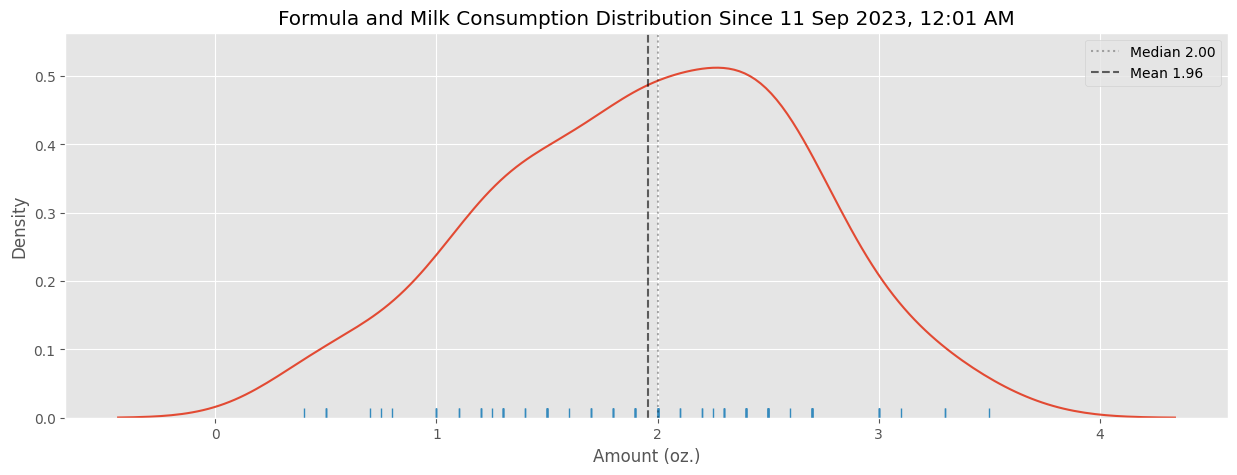

In [7]:
to_analyze = timedelta(days=7)
feeding_df = (pd.concat((get_data(files_dict['Andrew_formula']).rename(columns={'Amount (oz.)':'Formula (oz.)'}),
                        get_data(files_dict['Andrew_expressed']).rename(columns={'Amount (oz.)':'Milk (oz.)'})),axis=1)
                        .drop(columns=['Note'])
                        .assign(Amount = lambda x: x['Formula (oz.)'].fillna(x['Milk (oz.)']))
                        .rename(columns={'Amount':'Amount (oz.)'})
                        .sort_index())

feeding_df['hour_of_day'] = [x.hour for x in feeding_df.index]
start_date = (feeding_df.index[-1] - to_analyze)
analysis_flt = feeding_df.index > start_date
feeding_df['rolling mean'] = feeding_df['Amount (oz.)'].rolling(to_analyze).mean()
feeding_df['rolling median'] = feeding_df['Amount (oz.)'].rolling(to_analyze).median()
stats = feeding_df.loc[analysis_flt].describe()
display(stats[['Formula (oz.)','Milk (oz.)','Amount (oz.)']])
mean = stats.at['mean','Amount (oz.)']
median = stats.at['50%','Amount (oz.)']
ax=sns.kdeplot(data=feeding_df.loc[analysis_flt],x='Amount (oz.)')
ax=sns.rugplot(data=feeding_df.loc[analysis_flt],x='Amount (oz.)',ax=ax)
ax.axvline(median,color='k',linestyle='dotted',label=f'Median {median:0.2f}',alpha=0.3)
ax.axvline(mean,color='k',linestyle='dashed',label=f'Mean {mean:0.2f}',alpha=0.6)
ax.legend()
s = datetime.strftime(start_date,'%d %b %Y, %I:%M %p')
_=ax.set_title(f'Formula and Milk Consumption Distribution Since {s}')

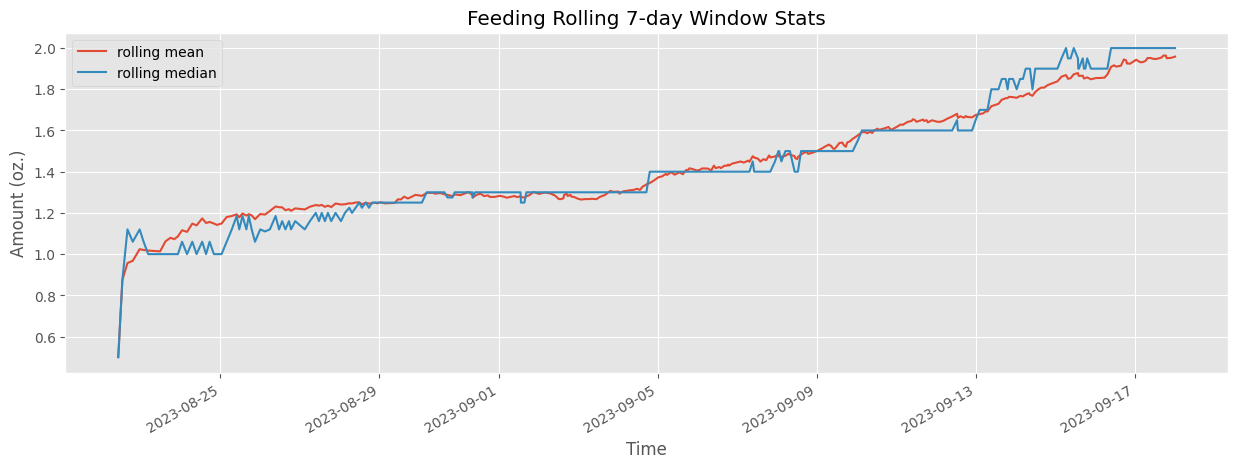

In [8]:
ax = feeding_df[['rolling mean','rolling median']].dropna().plot()
ax.set_ylabel('Amount (oz.)')
_=ax.set_title(f'Feeding Rolling {to_analyze.days}-day Window Stats')

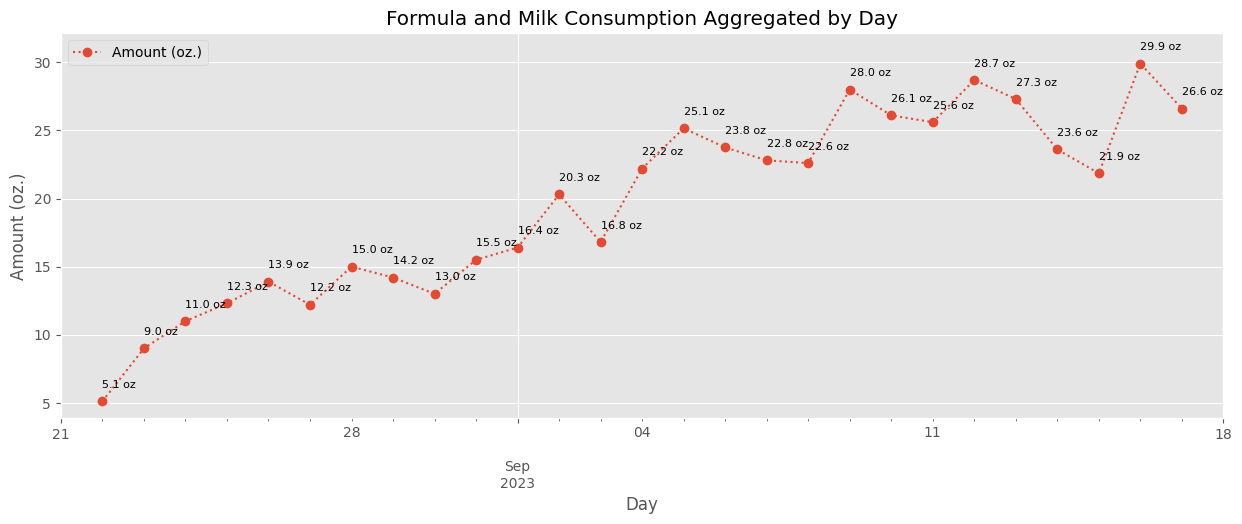

In [9]:
today = datetime.combine(datetime.now().date(), datetime.min.time())
tdf = feeding_df.resample('D').sum()['Amount (oz.)']
tdf = pd.DataFrame(tdf.loc[tdf.index<today]) # drop incomplete day
tdf['x'] = range(1,len(tdf.index)+1)
ax = tdf[['Amount (oz.)']].plot(marker='o',linestyle='dotted')
ax.set_xlim(tdf.index[0]-timedelta(days=1),tdf.index[-1]+timedelta(days=1))
yl = ax.get_ylim()
offset = 1.0
ax.set_ylim(yl[0],yl[1]+offset)
for x, y in zip(tdf.index, tdf['Amount (oz.)'].values):
    ax.text(x, y+offset, f"{y:0.1f} oz", fontsize=8)
ax.set_ylabel('Amount (oz.)')
ax.set_xlabel('Day')
ax.legend(loc='upper left')
_=ax.set_title('Formula and Milk Consumption Aggregated by Day')

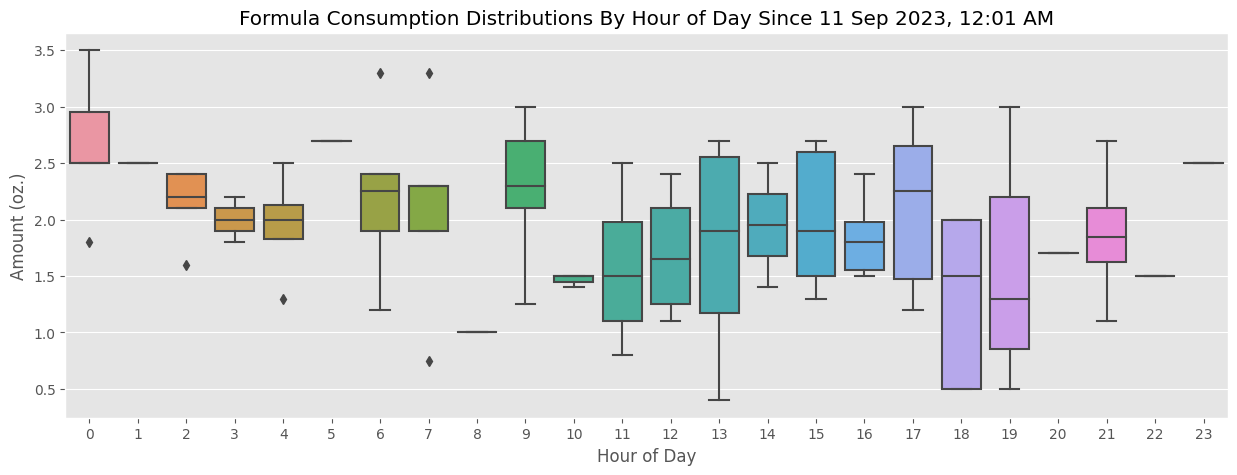

In [28]:
ax=sns.boxplot(data=feeding_df.loc[analysis_flt],y='Amount (oz.)',x='hour_of_day')
ax.set_title(f'Formula Consumption Distributions By Hour of Day Since {s}')
_=ax.set_xlabel('Hour of Day')